# <font color=red>3.4. Region Extraction for better brain parcellations 

In [2]:
from nilearn import plotting, image, datasets

In [3]:
adhd_dataset = datasets.fetch_adhd(n_subjects=20)
func_filenames = adhd_dataset.func
confounds = adhd_dataset.confounds

/Users/amr/anaconda3/lib/python3.7/site-packages/nilearn/datasets/func.py:503: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype=None)


In [4]:
from nilearn.decomposition import DictLearning

In [5]:
dict_learning = DictLearning(n_components=5, smoothing_fwhm=6., memory='nilearn_cache', memory_level=2, random_state=0)

In [6]:
dict_learning.fit(func_filenames)

/Users/amr/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


DictLearning(alpha=10, batch_size=20, detrend=True, dict_init=None,
       high_pass=None, low_pass=None, mask=None, mask_args=None,
       mask_strategy='epi', memory=Memory(location=nilearn_cache/joblib),
       memory_level=2, method='cd', n_components=5, n_epochs=1, n_jobs=1,
       random_state=0, reduction_ratio='auto', smoothing_fwhm=6.0,
       standardize=True, t_r=None, target_affine=None, target_shape=None,
       verbose=0)

In [7]:
components_img = dict_learning.components_img_

/Users/amr/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:942: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


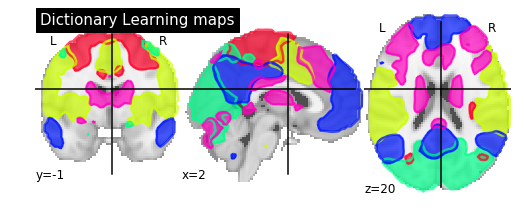

In [8]:
plotting.plot_prob_atlas(components_img, view_type='filled_contours', title='Dictionary Learning maps')

In [9]:
from nilearn.regions import RegionExtractor

In [13]:
#you have to add the input here, unlike everything else
extractor = RegionExtractor(components_img, threshold=0.5,
                           thresholding_strategy='ratio_n_voxels',
                            extractor='local_regions', standardize=True, min_region_size=1350)

In [14]:
extractor.fit()

/Users/amr/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


RegionExtractor(detrend=False, extractor='local_regions', high_pass=None,
        low_pass=None,
        maps_img=<nibabel.nifti1.Nifti1Image object at 0x1c18b718d0>,
        mask_img=None, memory=Memory(location=None), memory_level=0,
        min_region_size=1350, smoothing_fwhm=6, standardize=True, t_r=None,
        threshold=0.5, thresholding_strategy='ratio_n_voxels', verbose=0)

In [15]:
regions_extracted_img = extractor.regions_img_
regions_index = extractor.index_
n_regions_extracted = regions_extracted_img.shape[-1]

In [16]:
title = ('{0} regions are extracted from {1} components.'
        '\nEach seperated color of region indicates extracted region'.format(n_regions_extracted, 5))

/Users/amr/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:942: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')
/Users/amr/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/Users/amr/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:2788: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


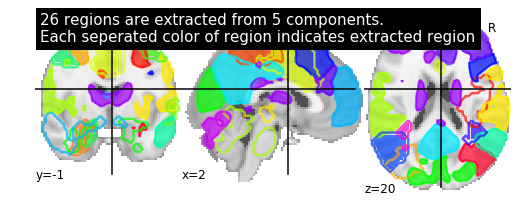

In [17]:
plotting.plot_prob_atlas(regions_extracted_img, view_type='filled_contours', title=title)

Notice that we have only 5 components, but 26 regions, because when you apply the thresholding, you lose a lot 
components, like the water between two islands

### 8.4.13.4. Compute correlation coefficients

In [20]:
from nilearn.connectome import ConnectivityMeasure

In [21]:
correlations = []

In [22]:
connectome_measure = ConnectivityMeasure(kind='correlation')
for filename, confound in zip(func_filenames, confounds):
    timeseries_each_subject = extractor.transform(filename, confounds=confound)
    correlation = connectome_measure.fit_transform([timeseries_each_subject])
    correlations.append(correlation)

In [23]:
import numpy as np
mean_correlations = np.mean(correlations, axis=0).reshape(n_regions_extracted,
                                                         n_regions_extracted)

In [26]:
title = 'correlation between {0} regions'.format(n_regions_extracted)

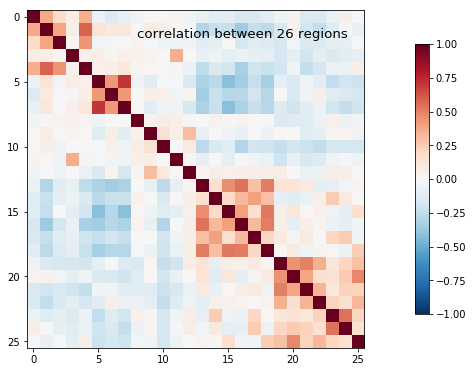

In [27]:
display = plotting.plot_matrix(mean_correlations, vmax=1, vmin=-1,
                              colorbar=True, title=title)

In [28]:
#then find the center of the rgions and plot a connectome
regions_img = regions_extracted_img

/Users/amr/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


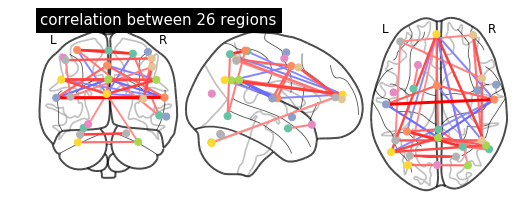

In [31]:
coords_connectome = plotting.find_probabilistic_atlas_cut_coords(regions_img)
plotting.plot_connectome(mean_correlations, coords_connectome, edge_threshold='90%', title=title)

<font color=orange>plotting.find_xyz_cut_coords -> Find the center of the largest activation connected component. 

<font color=blue>that's why it works for finding coords of an idependent component

<font color=orange>plotting.find_probabilistic_atlas_cut_coords ->Return coordinates of center probabilistic atlas 4D image

<font color=blue>that's why it works with ROIs


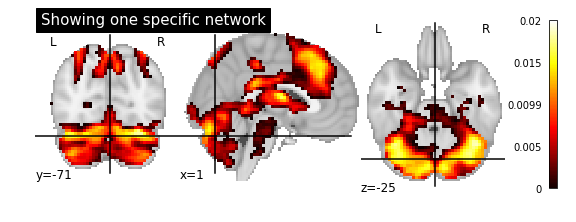

In [35]:
img = image.index_img(components_img, 4)
coords = plotting.find_xyz_cut_coords(img)
display = plotting.plot_stat_map(img, cut_coords=coords, title='Showing one specific network')

/Users/amr/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:2788: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


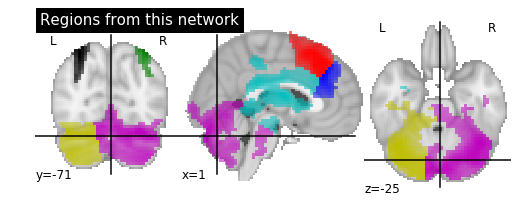

In [37]:
regions_indices_of_map3 = np.where(np.array(regions_index) == 4)


display = plotting.plot_anat(cut_coords=coords, title='Regions from this network')

colors = 'rgbcmyk'
for each_index_of_mp3, color in zip(regions_indices_of_map3[0], colors):
    display.add_overlay(image.index_img(regions_extracted_img, each_index_of_mp3), 
                        cmap=plotting.cm.alpha_cmap(color))

In [45]:
regions_indices_of_map3[0].shape

(7,)

In [39]:
regions_index

[0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4]